In [45]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs


%matplotlib inline
plt.style.use('ggplot')


 Nguyen Ngo 's code to generate test data for A|B testing  
   Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)

In [46]:
def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
        data = []
        N = N_A + N_B
        group_bern = scs.bernoulli(0.5)
        A_bern = scs.bernoulli(p_A)
        B_bern = scs.bernoulli(p_B)
        for idx in range(N):
        # initite empty row
            row = {}
        # for 'ts' column
            if days is not None:
                if type(days) == int:
                    row['ts'] = idx // (N // days)
                else:
                    raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
            row['group'] = group_bern.rvs()

            if row['group'] == 0:
            # assign conversion based on provided parameters
                row['converted'] = A_bern.rvs()
            else:
                row['converted'] = B_bern.rvs()
        # collect row into data container
            data.append(row)

    # convert data into pandas dataframe
        df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
        df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

        return df
            

In [47]:
N_A = 1000
N_B = 1000
p_A = 0.10
p_B = 0.12

In [48]:
ab_data = generate_data(N_A,N_B,p_A,p_B)

In [49]:
ab_data.head(3)

,converted,group
0,0,A
1,0,B
2,0,A


In [50]:
ab_data.shape

(2000, 2)

In [51]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

In [52]:
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(102, 115)

In [53]:

A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(1000, 1000)

In [54]:
p_A, p_B = A_converted / A_total, B_converted / B_total
p_A, p_B

(0.102, 0.115)

In [55]:
p_B - p_A

0.013000000000000012

In [56]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [57]:
ab_summary

,converted,total,rate
group,,,
A,102,1000,0.102
B,115,1000,0.115


The above result matches our parameters that we used to set up the test. Keep in mind that you will not be able to set how much lift you would see in the test group in real-world applications. However, you do have to decide how many samples you will need for the test and you will probably know the baseline conversion rate.

If you observe the conversion rate for both groups, you find that the new signup page resulted in an improvement of 2%. This is good news, but how can you demonstrate that this result is statistically significant.

In [58]:
p_B * A_total

115.0

Text(0,0.5,'probability')

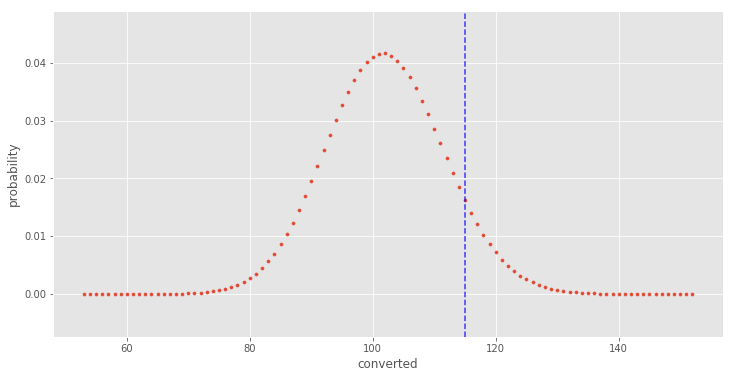

In [59]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, p_A).pmf(x)
ax.scatter(x, y, s=10)
ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

If we plot the binomial distribution that corresponds to the control group we would get the plot above in red. If we want to evaluate the probability of getting the result from the test group based on the binomial distribution from the control group, we would get the following:

In [60]:
scs.binom(A_total, p_A).pmf(116)

0.014064060101112445

That is a very low probability. If we are comparing this to a significance level, typically referred to as alpha, we would say that the result is drastically lower than 5% or even 1%. In other words, there was a 0.2% chance that we would have seen this result. Is this enough evidence of statistical significance? Let's get into statistical power.

We can plot the data from both groups as binomial distributions.

Text(0,0.5,'probability')

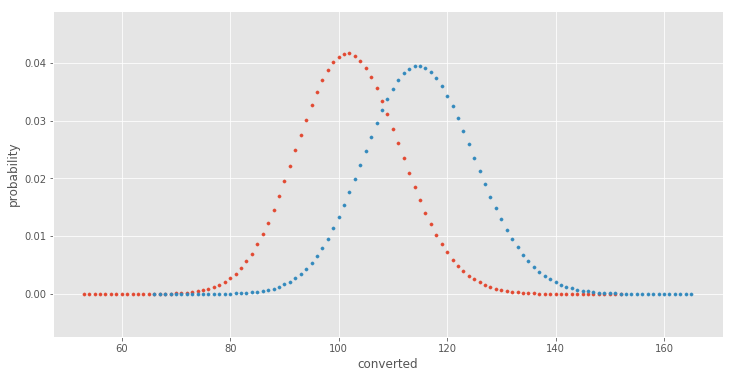

In [61]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.scatter(xA, yA, s=10)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.scatter(xB, yB, s=10)
plt.xlabel('converted')
plt.ylabel('probability')


We can see that the test group converted more users than the control group. However, the plot above is not a plot of the null and alternate hypothesis. The null hypothesis is a plot of the difference between the probability of the two groups.In order to calculate the difference between the two groups, we need to standardize the data. Because the number of samples might be different between the two groups, we should compare the probability of successes, p.

In [62]:

SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_A

0.009570579919733181

In [63]:

SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
SE_B

0.010088359628799918

Text(0,0.5,'PDF')

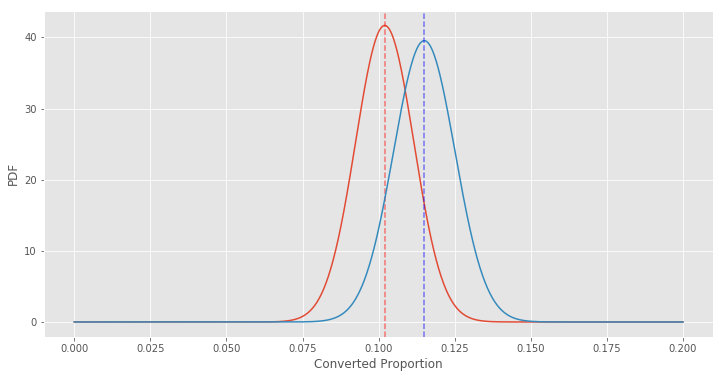

In [64]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .2, 1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')


The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to d_hat.

$$ \hat{d} = \hat{p}_B - \hat{p}_A $$


Back to the Null and Alternate Hypothesis
Recall that the null hypothesis states that the difference in probability between the two groups is zero. We should construct a distribution of this difference, since for any A/B experiment our value for p each come from a two different distributions and the difference will have its own variance.

$$ H_0: d = 0 $$$$ \hat{d} \sim Normal(0, \: SE_{pool}) $$
$$ H_A: d = p_B - p_A $$$$ \hat{d} \sim Normal(d, \: SE_{pool}) $$
Variance of the Sum

The variance of the sum (of two random independent variables) is the sum of the variances.

$$ Var(X + Y) = Var(X) + Var(Y) $$$$ Var(X - Y) = Var(X) + Var(Y) $$
Because the distribution for the difference is calculated from two normal distributions, we can assume that the difference will be normally distributed.

The null hypothesis is the normal distribution of the difference with a mean of zero.

The alternate hypothesis is the normal distribution of the difference with a mean of the difference in the means of the two groups.

The null hypothesis and alternate hypothesis will the same variance which will be the sum of the variances for the control group and the test group.

$$ Var(\hat{d}) = Var(\hat{p}_B - \hat{p}_A) = Var(\hat{p}_A) + Var(\hat{p}_B) = \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} $$
The standard deviation will be the square root of the variance.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} } $$
Pooled Variance
We can put this equation in terms of $s$, where $s$ is the standard deviation of the Bernoulli distribution.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_A^2}{n_A} + \frac{s_B^2}{n_B} } $$